In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tifffile


import pppc
from pppc.configs import InferenceConfigDict
from pppc.core import PtychoNNProbePositionCorrector, ProbePositionCorrectorChain
from pppc.ptychonn.model import PtychoNNModel
from pppc.io import DataFileHandle, NPZFileHandle, VirtualDataFileHandle
from pppc.position_list import ProbePositionList
from pppc.reconstructor import VirtualReconstructor
from pppc.util import class_timeit

In [43]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [119]:
scan_idx = 242
save_figs = True
output_dir = os.path.join('outputs', 'test{}'.format(scan_idx))
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

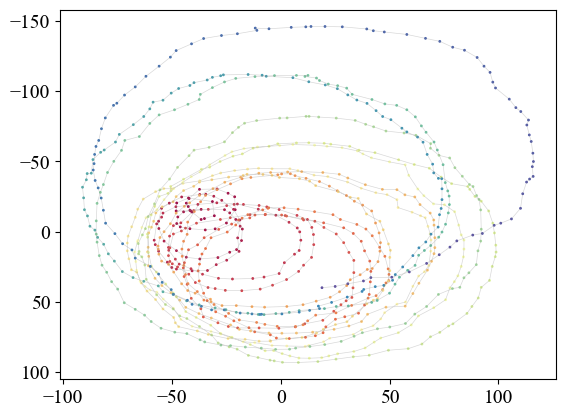

In [120]:
psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
probe_pos_list = ProbePositionList(file_path='data/pos{}.csv'.format(scan_idx),
                                   unit='m', psize_nm=psize_nm, convert_to_pixel=True, first_is_x=False)
fig, ax, scat = probe_pos_list.plot(show=False, return_obj=True)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_true.pdf'.format(scan_idx))
else:
    plt.show()

In [121]:
recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
config_dict = InferenceConfigDict()
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
# config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
config_dict['dp_data_file_handle'] = VirtualDataFileHandle('', dp_shape=recons.shape[1:], num_dps=recons.shape[0])
# config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['ptycho_reconstructor'] = VirtualReconstructor(InferenceConfigDict())
config_dict['ptycho_reconstructor'].set_object_image_array(recons)
config_dict['random_seed'] = 196 
config_dict['debug'] = False
config_dict['probe_position_list'] = None
config_dict['central_crop'] = None

Serial correction

In [122]:
config_dict.load_from_json(os.path.join('config_jsons', 'config_{}.json'.format(scan_idx)))
config_dict

batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: error_map
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f56fa7a9150>
probe_position_list: None
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.01
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f56ff4ced50>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 'sift', 'sift']
smooth_constraint_weight_multiiter: [0

In [123]:
corrector_chain = ProbePositionCorrectorChain(config_dict)
corrector_chain.build()

[2023-12-05 19:56:05,124] Now running iteration 0.
[2023-12-05 19:56:05,128] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f56fa7a9150>
probe_position_list: None
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: serial
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f56ff4ced50>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 'sift', 'sift']
smooth_constraint_weight_multiiter: [0, 0.01, 0.00

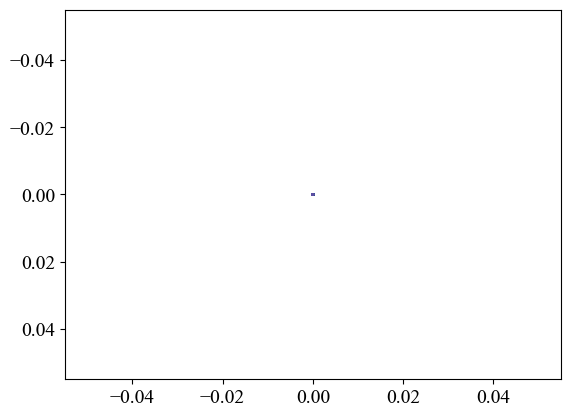

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [01:22<00:00, 11.68it/s]


In [124]:
corrector_chain.run_correction_iteration(0)

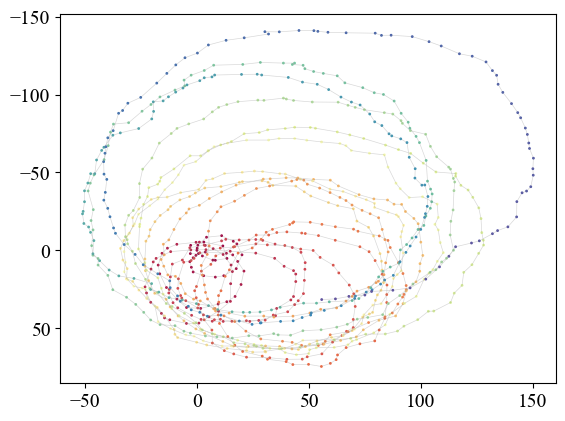

In [125]:
corrector_s = corrector_chain.corrector_list[-1]
fig, ax, scat = corrector_s.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_serial.pdf'.format(scan_idx))
else:
    plt.show()

[2023-12-05 19:57:29,040] Now running iteration 1.
[2023-12-05 19:57:29,041] Using result from the last iteration to initialize probe position array...
[2023-12-05 19:57:29,042] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f56fa7a9150>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f56ff002790>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.01
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f56ff4ced50>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 

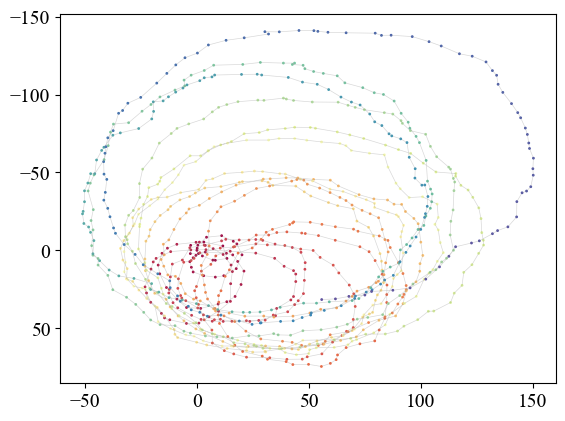

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [09:11<00:00,  1.74it/s]


In [126]:
# corrector_chain.config_dict['sift_outlier_removal_method'] = 'trial_error'
corrector_chain.run_correction_iteration(1)

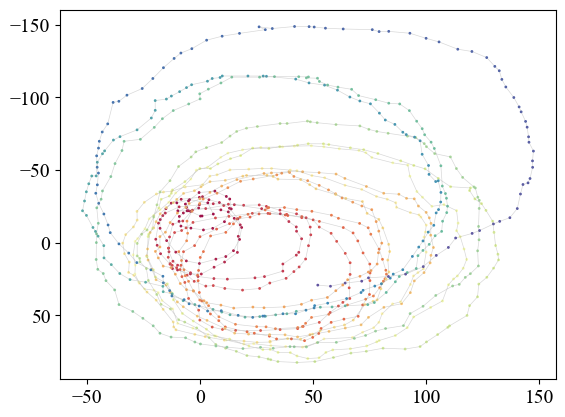

In [127]:
corrector_c1 = corrector_chain.corrector_list[1]
fig, ax, scat = corrector_c1.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_1_nn_12_sw_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

[2023-12-05 20:06:42,194] Now running iteration 2.
[2023-12-05 20:06:42,195] Using result from the last iteration to initialize probe position array...
[2023-12-05 20:06:42,196] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f56fa7a9150>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f56e5b76ed0>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.001
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f56ff4ced50>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift',

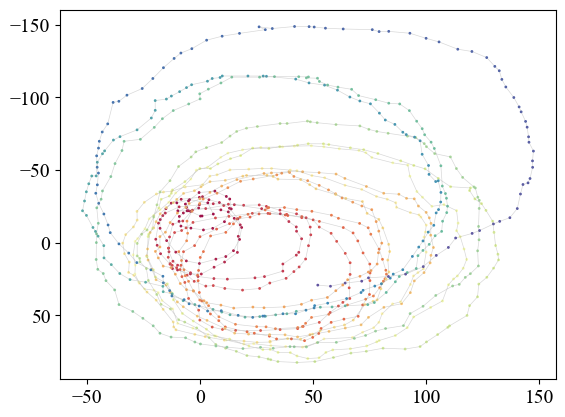

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [09:03<00:00,  1.77it/s]


In [128]:
corrector_chain.run_correction_iteration(2)

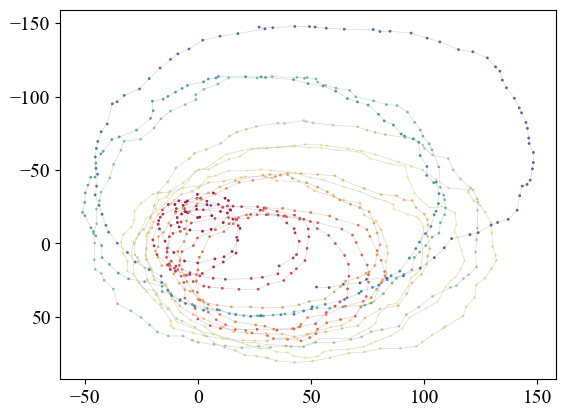

In [129]:
corrector_c2 = corrector_chain.corrector_list[2]
fig, ax, scat = corrector_c2.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

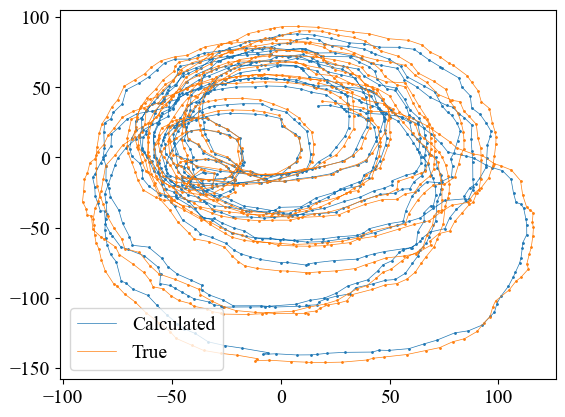

In [130]:
probe_pos_list_calc = corrector_c2.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (psize_nm * 1e-9)
probe_pos_list_calc -= np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
# probe_pos_list_raw *= 1.05
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
if save_figs:
    plt.savefig('outputs/test{}/comparison_path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()

In [131]:
if save_figs:
    corrector_c2.new_probe_positions.to_csv(os.path.join(output_dir, 'calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx)), psize_nm=psize_nm)